In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt

# 1. Embedding Network 
- 16차원을 임계값으로 저차원/ 고차원 결정
- 고차원 데이터의 경우 16으로 (네트워크의 입력 및 출력 특징 크기는 (입력 크기, 256), (256, 64), (64, 16))
- 저차원 데이터의 경우는 2로 ((입력 크기, 64), (64, 16), (16, 2))함.
- 모든 은닉층에 사용되는 활성화 함수는 ReLU이며, 출력층의 활성화 함수는 시그모이드 함수를 사용.


## Embedding Network structure of DDHS
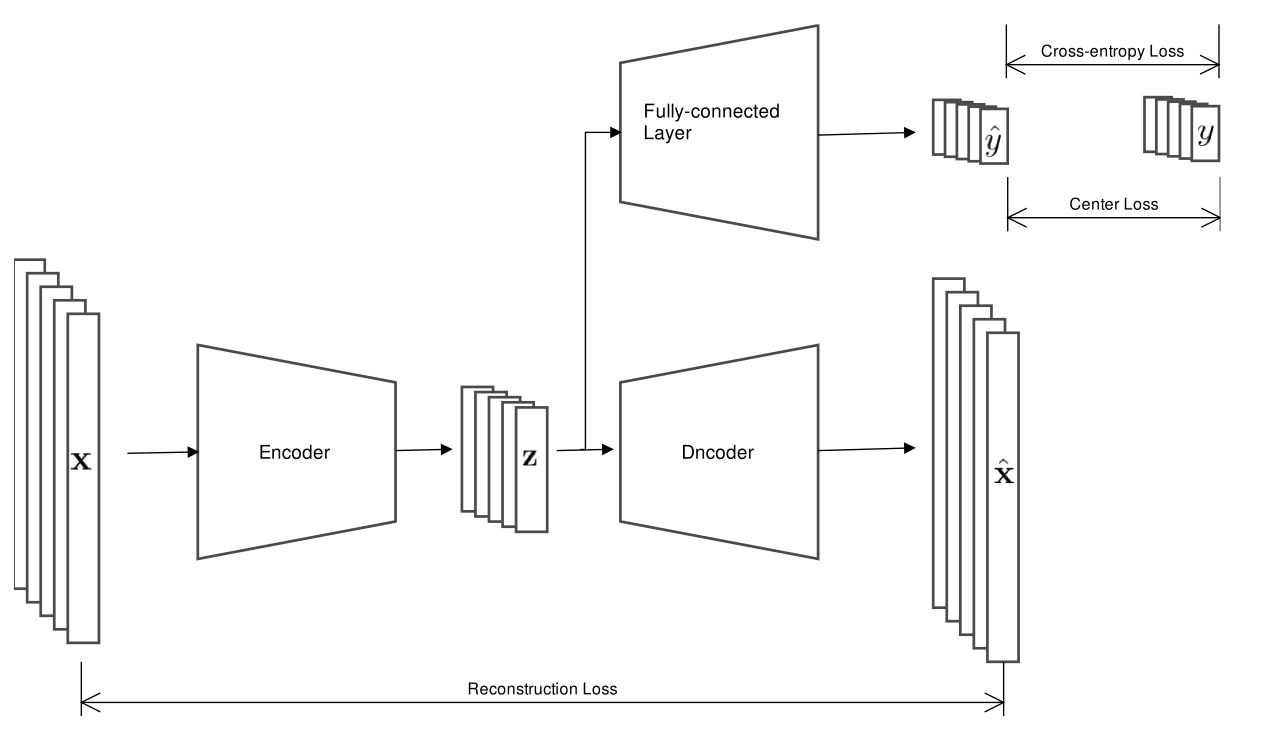

In [45]:
class HighDimAutoencoder(nn.Module):
  def __init__(self, input_dim):
    super(HighDimAutoencoder, self).__init__()
    # 인코더
    self.encoder = nn.Sequential(
        nn.Linear(input_dim, 256),
        nn.ReLU(),
        nn.Linear(256, 64),
        nn.ReLU(),
        nn.Linear(64, 16)
    )
    # 디코더
    self.decoder = nn.Sequential(
        nn.Linear(16, 64),
        nn.ReLU(),
        nn.Linear(64, 256),
        nn.ReLU(),
        nn.Linear(256, input_dim),
        nn.Sigmoid()
    )
  def forward(self, x):
    z = self.encoder(x)
    x_hat = self.decoder(z)
    return z, x_hat

class LowDimAutoencoder(nn.Module):
    def __init__(self, input_dim):
        super(LowDimAutoencoder, self).__init__()
        # 인코더
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 2)
        )
        # 디코더
        self.decoder = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return z, x_hat

def select_autoencoder(data):
    input_dim = data.shape[1]
    if input_dim > 16:
        model = HighDimAutoencoder(input_dim)
        latent_dim = 16 # 추후 FC layer에 사용
    else:
        model = LowDimAutoencoder(input_dim)
        latent_dim = 2
    return model, latent_dim


## 1-1. 데이터 생성

In [46]:
mnist = fetch_openml('mnist_784')
X, y = mnist['data'], mnist['target'].astype(int)

# 데이터 정규화 및 텐서 변환
X = (X / 255.0).astype(np.float32)
data = torch.tensor(X.values)
labels = torch.tensor(y.values)

# 데이터 및 레이블 크기 확인
print("X_tensor shape:", data.shape)
print("y_tensor shape:", labels.shape)


X_tensor shape: torch.Size([70000, 784])
y_tensor shape: torch.Size([70000])


## 1-2.데이터 시각화

In [47]:
for label in range(10):
    num_samples = len(labels[labels == label])
    print(f"클래스 {label}의 샘플 수: {num_samples}")

클래스 0의 샘플 수: 6903
클래스 1의 샘플 수: 7877
클래스 2의 샘플 수: 6990
클래스 3의 샘플 수: 7141
클래스 4의 샘플 수: 6824
클래스 5의 샘플 수: 6313
클래스 6의 샘플 수: 6876
클래스 7의 샘플 수: 7293
클래스 8의 샘플 수: 6825
클래스 9의 샘플 수: 6958


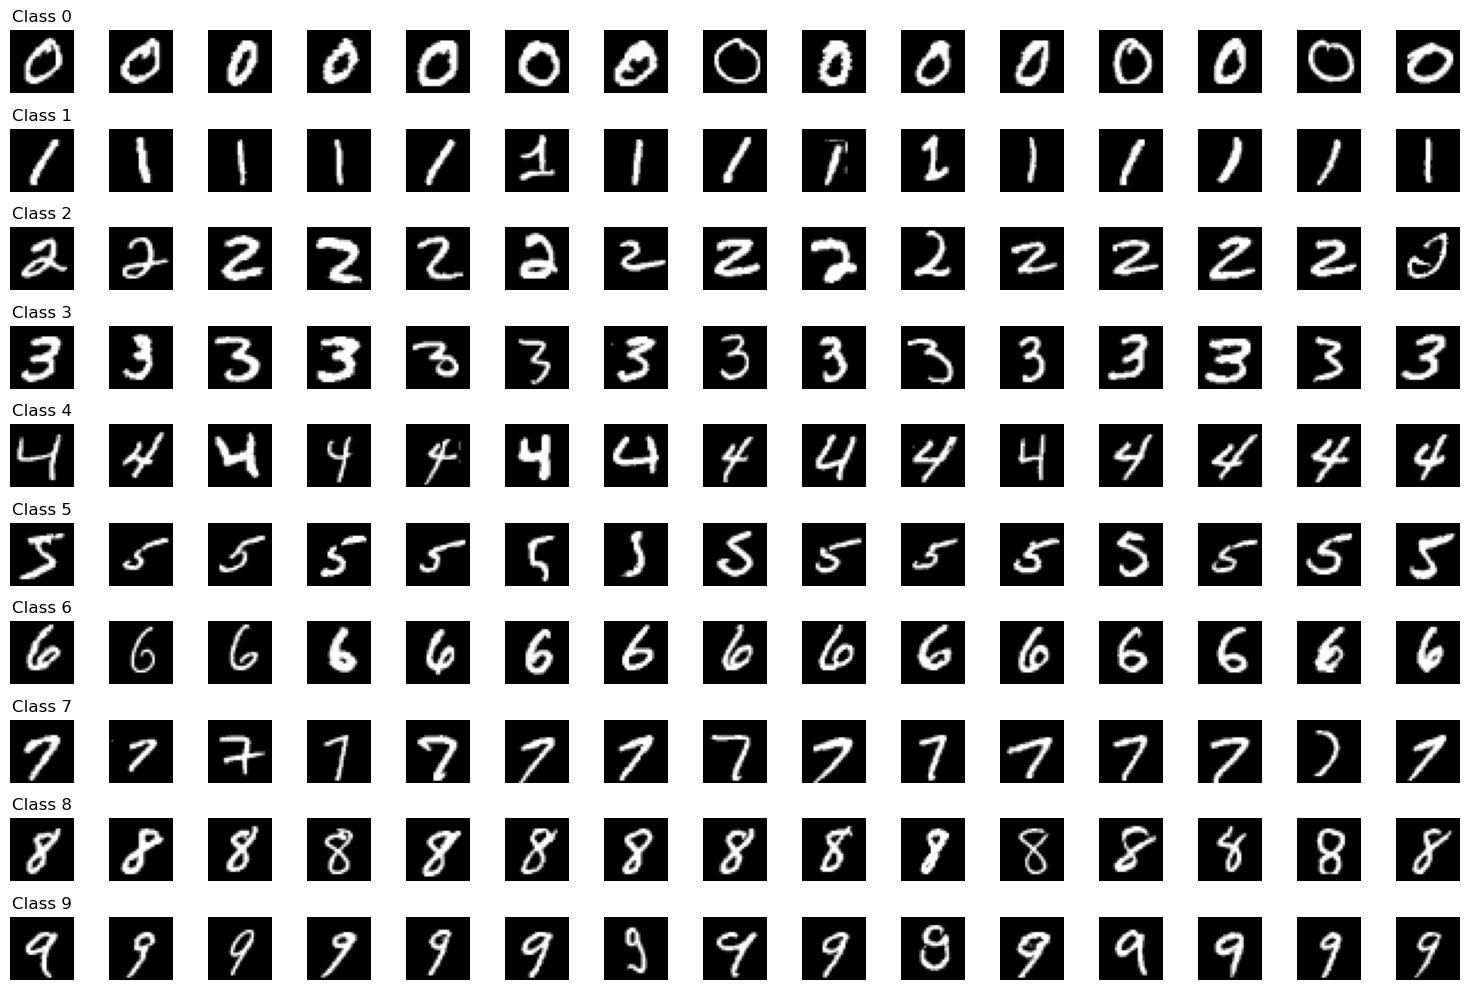

In [48]:
import matplotlib.pyplot as plt
import numpy as np

def plot_samples(data, labels, num_samples=15):
    unique_labels = np.unique(labels)
    num_classes = len(unique_labels)
    
    fig, axes = plt.subplots(num_classes, num_samples, figsize=(num_samples, num_classes))
    
    for i, cls in enumerate(unique_labels):
        cls_data = data[labels == cls]
        for j in range(min(num_samples, len(cls_data))):
            axes[i, j].imshow(cls_data[j].reshape(28, 28), cmap='gray')
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(f"Class {cls}")

    plt.tight_layout()
    plt.show()

plot_samples(data.numpy(), labels.numpy())


In [49]:
autoencoder, latent_dim = select_autoencoder(data)
z, x_hat = autoencoder(data)

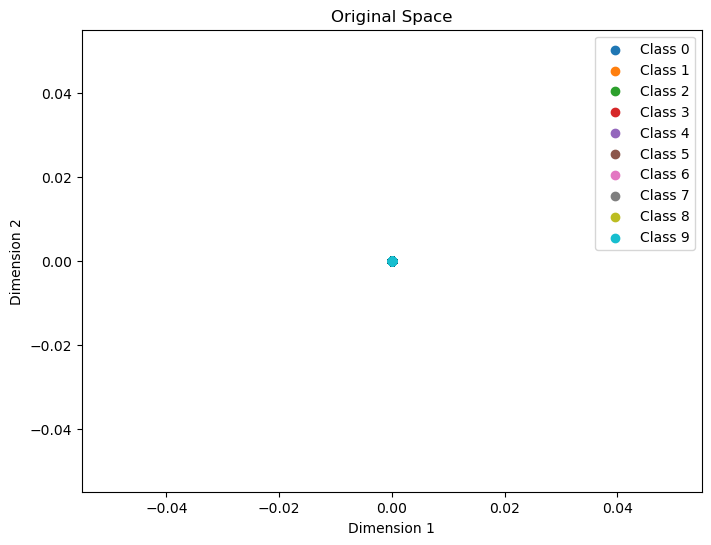

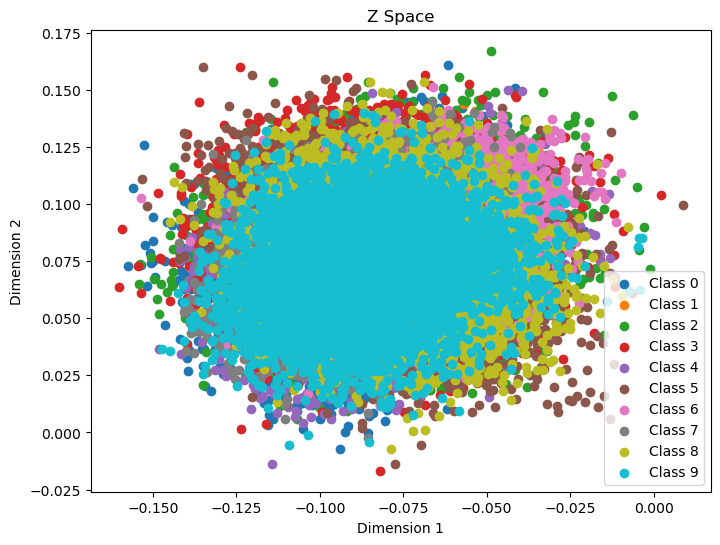

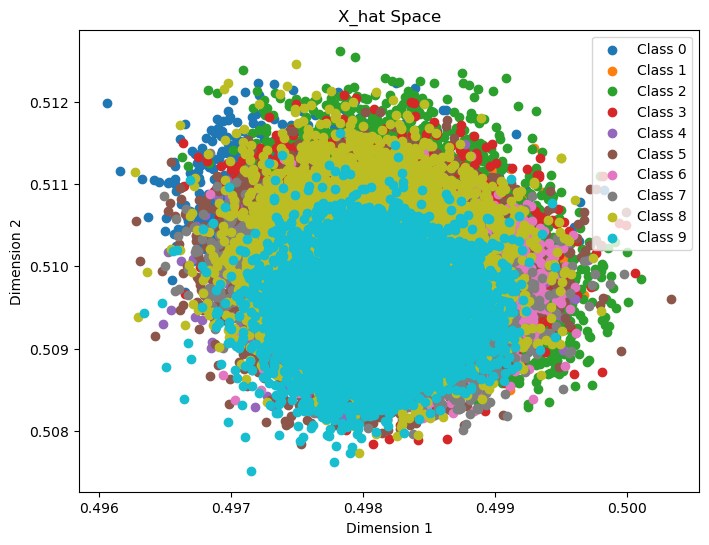

In [51]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 원본 데이터 시각화 (10차원이여서 의미없긴 한데)
plt.figure(figsize=(8, 6))
for label in torch.unique(labels):
    idx = labels == label
    plt.scatter(data[idx, 0], data[idx, 1], label=f'Class {label.item()}')
plt.title('Original Space')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

# z 시각화
z = z.detach().numpy()
plt.figure(figsize=(8, 6))
for label in torch.unique(labels):
    idx = labels == label
    plt.scatter(z[idx, 0], z[idx, 1], label=f'Class {label.item()}')
plt.title('Z Space')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()


# x_hat 시각화 (10차원이여서 의미없긴 한데)
x_hat = x_hat.detach().numpy()
plt.figure(figsize=(8, 6))
for label in torch.unique(labels):
    idx = labels == label
    plt.scatter(x_hat[idx, 0], x_hat[idx, 1], label=f'Class {label.item()}')
plt.title('X_hat Space')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

### 어우 징그러..

## 1-3. z에 Fully-connected Layer 연결 (z의 클래스 예측)

In [41]:
class Classifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(Classifier, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

num_classes=10
classifier = Classifier(input_dim=latent_dim, num_classes=num_classes)

# 2. Loss Function
- Reconstruction Loss = x, x_hat 간의 MSE
- between-class loss = z를 Fully-connected Layer을 한 y_hat과 y의 교차 엔트로피 손실
- within-class loss = 잠재 공간에서 yi 클래스의 중심인 Cyi와 zi의 L2규제의 배치 사이즈 합의 1/2

In [42]:
# Reconstruction Loss
reconstruction_criterion = nn.MSELoss()

# between-class loss
classification_criterion = nn.CrossEntropyLoss()

# within_class loss
# 클래스 중심(Cyi) 계산
def compute_class_centers(z, labels, num_classes):
    centers = torch.zeros(num_classes, z.size(1))
    for i in range(num_classes):
        class_points = z[labels == i] #label이 i일 때 해당하는 인덱스를 z에서 찾음)
        if len(class_points) > 0: # label에 맞는 데이터가 1 이상이면,
            centers[i] = class_points.mean(dim=0) # 그 데이터의 평균을 구함. (이것이 클래스 중심.)
    return centers

def within_class_loss(z, labels, centers):
    loss = 0
    for i in range(len(z)):
        center = centers[labels[i]]
        loss += torch.norm(z[i] - center, p=2) ** 2
    return loss / 2


## 2-1. Embedding Network training

Epoch [10/150], Total Loss: 3.3249, Reconstruction Loss: 0.2116, Classification Loss: 2.3123, Within-Class Loss: 0.8010


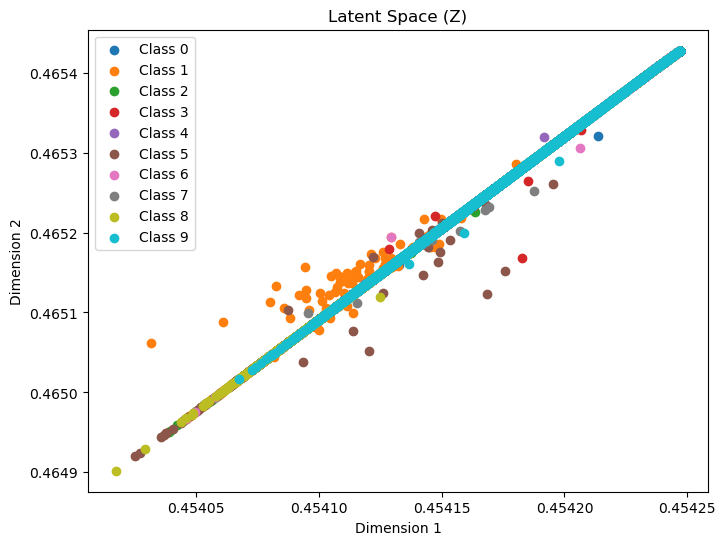

Epoch [20/150], Total Loss: 2.7962, Reconstruction Loss: 0.1705, Classification Loss: 2.3093, Within-Class Loss: 0.3164


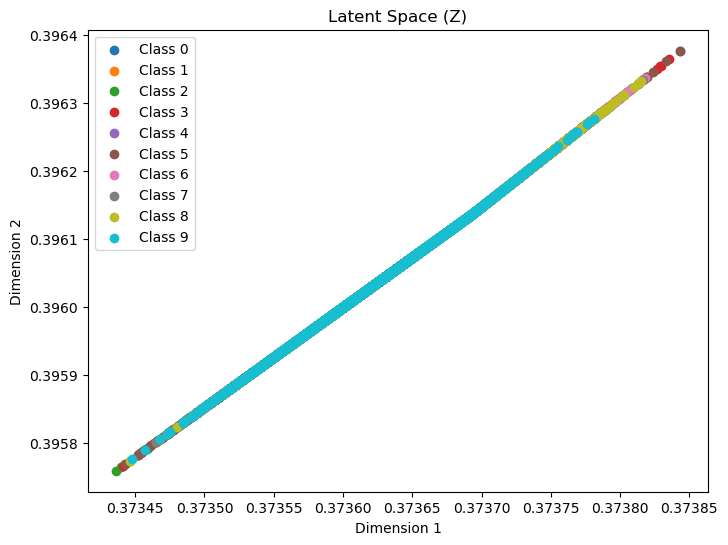

KeyboardInterrupt: 

In [43]:
# 모델 학습
epochs = 150
optimizer = optim.Adam(list(autoencoder.parameters()) + list(classifier.parameters()), lr=1e-3)
for epoch in range(epochs):
    autoencoder.train()
    classifier.train()

    optimizer.zero_grad()

    # Forward pass
    z, x_hat = autoencoder(data)
    y_hat = classifier(z)

    # 손실 계산
    reconstruction_loss = reconstruction_criterion(x_hat, data)
    classification_loss = classification_criterion(y_hat, labels)
    class_centers = compute_class_centers(z, labels, num_classes)
    within_loss = within_class_loss(z, labels, class_centers)

    total_loss = reconstruction_loss + classification_loss + within_loss
    total_loss.backward()

    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Total Loss: {total_loss.item():.4f}, Reconstruction Loss: {reconstruction_loss.item():.4f}, Classification Loss: {classification_loss.item():.4f}, Within-Class Loss: {within_loss.item():.4f}')

    # 학습된 잠재 공간 z 시각화
    if (epoch + 1) % 10 == 0:
        autoencoder.eval()
        with torch.no_grad():
            _, z = autoencoder(data)
            z = z.detach().numpy()
            plt.figure(figsize=(8, 6))
            for label in torch.unique(labels):
                idx = labels == label
                plt.scatter(z[idx, 0], z[idx, 1], label=f'Class {label.item()}')
            plt.title('Latent Space (Z)')
            plt.xlabel('Dimension 1')
            plt.ylabel('Dimension 2')
            plt.legend()
            plt.show()


# 3. Density-Based Filtering
- 일단, 가우시안 필터 KDE를 통해 밀도를 계산함.
- bandwidth(h)계산은 scott 규칙 사용.
- z_majority 경우 두 번째 사분위 (Q2, 그러니까 상위 50%) 이상의 밀도의 샘플을 선택
- z_minority 경우 세 번째 사분위(Q3, 그러니까 상위 25%) 이상의 밀도의 샘플을 선택

In [ ]:
import numpy as np
from sklearn.neighbors import KernelDensity
from scipy.stats import iqr

def compute_density(data):
    # Scott's rule for bandwidth
    data = data.numpy()
    m, d = data.shape # m = 샘플 수, d = 차원 수
    bandwidth = np.power(m, -1./(d+4)) * np.std(data, axis=0, ddof=1).mean()
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(data)
    log_density = kde.score_samples(data)
    return np.exp(log_density)

density_majority = compute_density(z_majority)
density_minority = compute_density(z_minority)